In [1]:
# !pip install post-analysis-clustering

# Load data

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from post_analysis_clustering.utils import timer

In [4]:
from sklearn.datasets import load_iris
import pandas as pd

iris = load_iris()
df_iris = pd.DataFrame(iris.data, columns=iris.feature_names)
df_iris['species'] = iris.target
df_iris['species_name'] = df_iris['species'].map(dict(zip(range(3), iris.target_names)))
df_iris = df_iris.reset_index(names='id')
df_iris = df_iris.drop(columns='species')

df_iris.head()

,id,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species_name
0,0,5.1,3.5,1.4,0.2,setosa
1,1,4.9,3.0,1.4,0.2,setosa
2,2,4.7,3.2,1.3,0.2,setosa
3,3,4.6,3.1,1.5,0.2,setosa
4,4,5.0,3.6,1.4,0.2,setosa


# Prep data

In [5]:
from post_analysis_clustering.prep_data import get_feature_list, get_numeric_feature_lists

In [6]:
iris_feature_list = get_feature_list(df=df_iris)
iris_feature_list

Execution time for get_feature_list: 0.0001 seconds


['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [7]:
# iris_feature_list = df_iris.drop(columns=['id','species_name'],axis=1).columns.to_list()
# iris_feature_list

In [8]:
cont_feature_list, disc_feature_list = get_numeric_feature_lists(df=df_iris, 
                                       primary_key='id', 
                                       target_cluster='species_name',
                                       nunique_threshold = 20)

Ignoring column 'id' — marked as primary key or target cluster.
Ignoring column 'species_name' — marked as primary key or target cluster.

Analyzing numerical features:
  • 'sepal length (cm)' has 35 unique values
    → Classified as CONTINUOUS (35 ≥ 20)
  • 'sepal width (cm)' has 23 unique values
    → Classified as CONTINUOUS (23 ≥ 20)
  • 'petal length (cm)' has 43 unique values
    → Classified as CONTINUOUS (43 ≥ 20)
  • 'petal width (cm)' has 22 unique values
    → Classified as CONTINUOUS (22 ≥ 20)
Execution time for get_numeric_feature_lists: 0.0023 seconds


In [9]:
cont_feature_list

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [10]:
disc_feature_list

[]

# Lean Features

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from scipy.stats import chi2_contingency
from matplotlib.colors import ListedColormap,Normalize
from post_analysis_clustering.utils import timer

In [15]:
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "HistGradientBoosting": HistGradientBoostingClassifier(random_state=42, early_stopping=True),
    "Logistic Regression": LogisticRegression(max_iter=2000, random_state=42),
    "Logistic Regression (L1)": LogisticRegression(penalty='l1', solver='liblinear', max_iter=2000, random_state=42),
    "Naive Bayes": GaussianNB()
}

In [16]:
from post_analysis_clustering.lean_feature.model_creation import ModelCreation
from post_analysis_clustering.lean_feature.select_feature_rank import LeanImportanceRank
from post_analysis_clustering.lean_feature.select_feature_thres import LeanImportanceThreshold

In [17]:
model_creation = ModelCreation(models=models,
                               n_rank=5,
                               pct_thres=0.8)

## Method : Top Rank 

In [18]:
lean_rank = LeanImportanceRank(
    df=df_iris,
    features=iris_feature_list,
    target_cluster="species_name",
    model_creation=model_creation,
    vote_score=3
)

final_imp, final_imp_score = lean_rank.RunModelCreation()

cluster_features_lr, union_features_lr = lean_rank.GetLeanFeature()

Running model creation and importance ranking...
Processing segment setosa
Execution time for _prep_binary_class: 0.0021 seconds

Training Decision Tree...
Execution time for _calculate_permutation_importance: 0.0836 seconds
Execution time for _train_and_evaluate_model: 0.0990 seconds

Training Random Forest...
Execution time for _calculate_permutation_importance: 0.3517 seconds
Execution time for _train_and_evaluate_model: 0.5134 seconds

Training HistGradientBoosting...
Execution time for _calculate_permutation_importance: 0.1491 seconds
Execution time for _train_and_evaluate_model: 0.2330 seconds

Training Logistic Regression...
Execution time for _calculate_permutation_importance: 0.0987 seconds
Execution time for _train_and_evaluate_model: 0.1183 seconds

Training Logistic Regression (L1)...
Execution time for _calculate_permutation_importance: 0.0797 seconds
Execution time for _train_and_evaluate_model: 0.0930 seconds

Training Naive Bayes...
Execution time for _calculate_permuta

In [15]:
final_imp

,Feature,Decision Tree,Random Forest,HistGradientBoosting,Logistic Regression,Logistic Regression (L1),Naive Bayes,Segment
0,petal length (cm),0.520000,0.073333,0.520000,0.515556,0.517778,0.260000,setosa
1,petal width (cm),0.000000,0.106667,0.000000,0.000000,0.000000,0.260000,setosa
2,sepal length (cm),0.000000,0.000000,0.000000,0.000000,0.000000,0.024444,setosa
3,sepal width (cm),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,setosa
4,petal length (cm),0.340000,0.124444,0.388889,0.077778,-0.020000,0.148889,versicolor
5,petal width (cm),0.106667,0.128889,0.128889,0.086667,0.080000,0.177778,versicolor
6,sepal length (cm),0.000000,0.000000,0.024444,0.006667,-0.013333,0.022222,versicolor
7,sepal width (cm),0.000000,0.000000,0.008889,0.031111,0.013333,0.044444,versicolor
8,petal length (cm),0.197778,0.131111,0.288889,0.273333,0.240000,0.128889,virginica
9,petal width (cm),0.242222,0.171111,0.104444,0.175556,0.184444,0.146667,virginica


In [16]:
final_imp_score

,Feature,1,2,3,4,Segment
0,petal length (cm),5,1,0,0,setosa
1,petal width (cm),2,4,0,0,setosa
2,sepal length (cm),0,5,1,0,setosa
3,sepal width (cm),0,4,2,0,setosa
4,petal length (cm),2,3,0,1,versicolor
5,petal width (cm),4,2,0,0,versicolor
6,sepal length (cm),0,0,4,2,versicolor
7,sepal width (cm),0,1,4,1,versicolor
8,petal length (cm),3,3,0,0,virginica
9,petal width (cm),3,3,0,0,virginica


Plotting heatmap for segment setosa


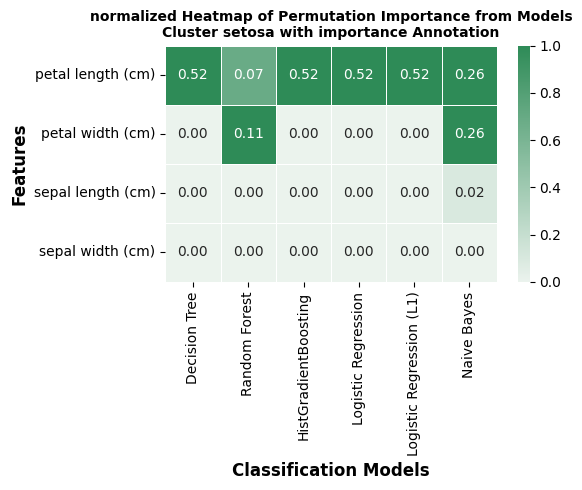

Plotting heatmap for segment versicolor


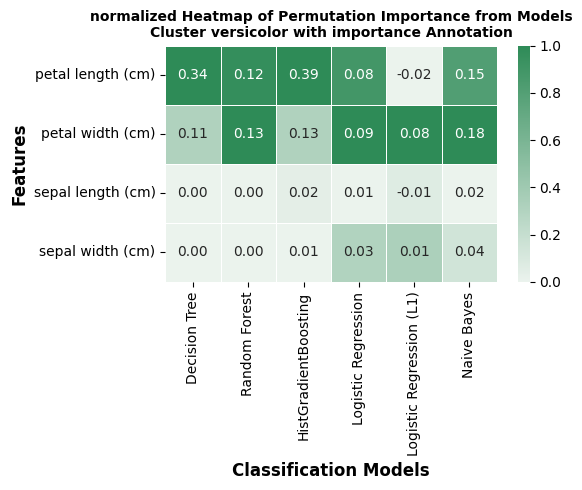

Plotting heatmap for segment virginica


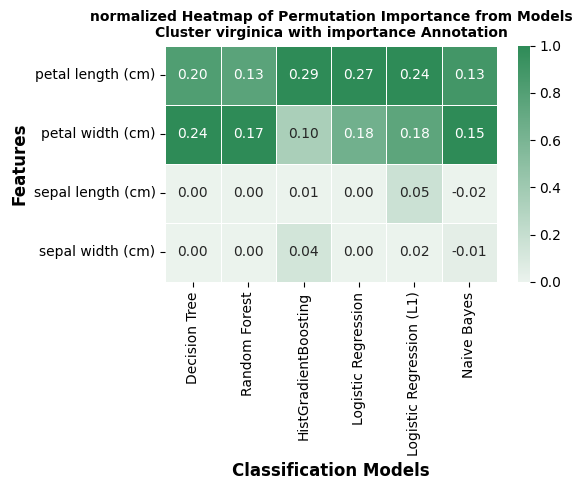

Execution time for PlotHeatmapScore: 0.8559 seconds


In [17]:
lean_rank.PlotHeatmapScore()

Plotting heatmap for segment setosa


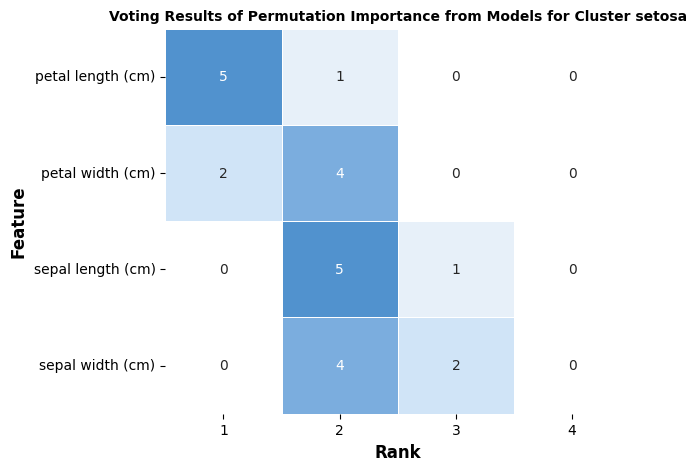

Plotting heatmap for segment versicolor


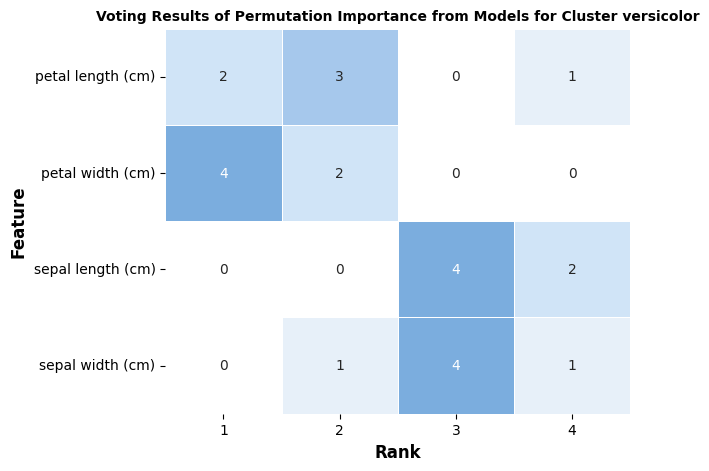

Plotting heatmap for segment virginica


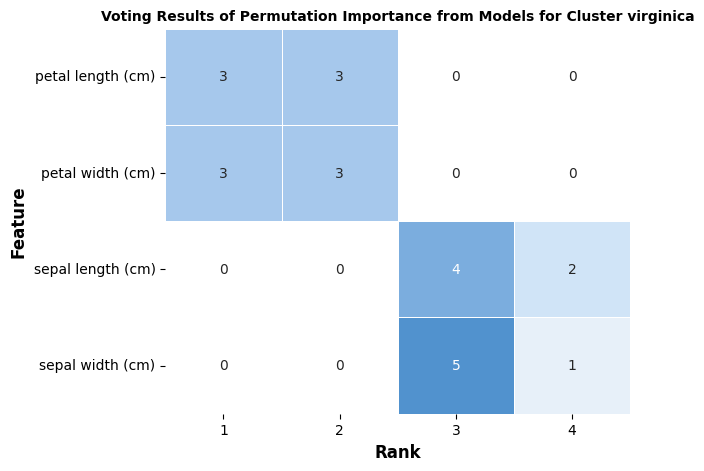

Execution time for PlotVoteRank: 0.4912 seconds


In [18]:
lean_rank.PlotVoteRank()

## Method : Threshold

In [19]:
lean_thres = LeanImportanceThreshold(
    df=df_iris,
    features=iris_feature_list,
    target_cluster="species_name",
    model_creation=model_creation,
    vote_score=3
)

final_cumsum_bin, final_cumsum_score = lean_thres.RunModelCreation()

cluster_features_lt, union_features_lt = lean_thres.GetLeanFeature()

Running model creation and importance ranking...
Processing segment setosa
Execution time for _prep_binary_class: 0.0025 seconds

Training Decision Tree...
Execution time for _calculate_permutation_importance: 0.0896 seconds
Execution time for _train_and_evaluate_model: 0.1035 seconds

Training Random Forest...
Execution time for _calculate_permutation_importance: 0.3642 seconds
Execution time for _train_and_evaluate_model: 0.5322 seconds

Training HistGradientBoosting...
Execution time for _calculate_permutation_importance: 0.1369 seconds
Execution time for _train_and_evaluate_model: 0.2067 seconds

Training Logistic Regression...
Execution time for _calculate_permutation_importance: 0.0978 seconds
Execution time for _train_and_evaluate_model: 0.1180 seconds

Training Logistic Regression (L1)...
Execution time for _calculate_permutation_importance: 0.0745 seconds
Execution time for _train_and_evaluate_model: 0.0882 seconds

Training Naive Bayes...
Execution time for _calculate_permuta

In [20]:
final_cumsum_bin

bin,Feature,single_imp,pct_20,pct_40,pct_60,pct_80,pct_99.99,pct_100,Segment
0,sepal width (cm),6,0,0,0,0,0,6,setosa
1,sepal length (cm),6,0,0,0,0,0,6,setosa
2,petal width (cm),0,0,0,1,0,1,4,setosa
3,petal length (cm),0,0,0,1,0,0,5,setosa
4,sepal width (cm),0,0,0,0,0,2,4,versicolor
5,sepal length (cm),0,0,0,0,0,1,5,versicolor
6,petal width (cm),0,0,0,3,0,2,1,versicolor
7,petal length (cm),0,0,0,0,2,2,2,versicolor
8,sepal width (cm),0,0,0,0,0,1,5,virginica
9,sepal length (cm),0,0,0,0,0,1,5,virginica


In [21]:
final_cumsum_score 

,Feature,single_imp,pct=<thres,Segment
0,sepal width (cm),6,0,setosa
1,sepal length (cm),6,0,setosa
2,petal width (cm),0,1,setosa
3,petal length (cm),0,1,setosa
4,sepal width (cm),0,0,versicolor
5,sepal length (cm),0,0,versicolor
6,petal width (cm),0,3,versicolor
7,petal length (cm),0,2,versicolor
8,sepal width (cm),0,0,virginica
9,sepal length (cm),0,0,virginica


## Method : Chi-Square Test

In [22]:
from post_analysis_clustering.lean_feature.select_feature_chisq import LeanChiSquare

In [23]:
lean_chisq = LeanChiSquare(
    df=df_iris,
    features=iris_feature_list,
    target_cluster="species_name",
    thres_logworth=3
)

binned_df = lean_chisq.PrepData(method = 'neg_zero_pos')

Execution time for PrepData: 0.0202 seconds


In [24]:
binned_df

,id,species_name,is_cluster_setosa,is_cluster_versicolor,is_cluster_virginica,sepal length (cm)_bin,sepal width (cm)_bin,petal length (cm)_bin,petal width (cm)_bin
0,0,setosa,1,0,0,"(5.02, 5.74]","(3.44, 3.92]","(1.00, 2.18]","(0.10, 0.58]"
1,1,setosa,1,0,0,"(4.30, 5.02]","(2.96, 3.44]","(1.00, 2.18]","(0.10, 0.58]"
2,2,setosa,1,0,0,"(4.30, 5.02]","(2.96, 3.44]","(1.00, 2.18]","(0.10, 0.58]"
3,3,setosa,1,0,0,"(4.30, 5.02]","(2.96, 3.44]","(1.00, 2.18]","(0.10, 0.58]"
4,4,setosa,1,0,0,"(4.30, 5.02]","(3.44, 3.92]","(1.00, 2.18]","(0.10, 0.58]"
...,...,...,...,...,...,...,...,...,...
145,145,virginica,0,0,1,"(6.46, 7.18]","(2.96, 3.44]","(4.54, 5.72]","(2.02, 2.50]"
146,146,virginica,0,0,1,"(5.74, 6.46]","(2.48, 2.96]","(4.54, 5.72]","(1.54, 2.02]"
147,147,virginica,0,0,1,"(6.46, 7.18]","(2.96, 3.44]","(4.54, 5.72]","(1.54, 2.02]"
148,148,virginica,0,0,1,"(5.74, 6.46]","(2.96, 3.44]","(4.54, 5.72]","(2.02, 2.50]"


In [25]:
final_cumsum_score

,Feature,single_imp,pct=<thres,Segment
0,sepal width (cm),6,0,setosa
1,sepal length (cm),6,0,setosa
2,petal width (cm),0,1,setosa
3,petal length (cm),0,1,setosa
4,sepal width (cm),0,0,versicolor
5,sepal length (cm),0,0,versicolor
6,petal width (cm),0,3,versicolor
7,petal length (cm),0,2,versicolor
8,sepal width (cm),0,0,virginica
9,sepal length (cm),0,0,virginica


In [26]:
pval_df,logworth_df = lean_chisq.TestChiSquare(method = 'neg_zero_pos')

Execution time for PrepData: 0.0197 seconds
List of binary class columns : ['is_cluster_setosa', 'is_cluster_versicolor', 'is_cluster_virginica']
List of binned features : ['sepal length (cm)_bin', 'sepal width (cm)_bin', 'petal length (cm)_bin', 'petal width (cm)_bin']

LogWorth scores calculated. Higher values = more significant.
Execution time for TestChiSquare: 0.0912 seconds


In [27]:
pval_df

,setosa,versicolor,virginica
sepal length (cm)_bin,2.780293e-17,5.294900e-04,3.252240e-13
sepal width (cm)_bin,8.947062e-12,2.608708e-07,2.437081e-02
petal length (cm)_bin,2.035764e-31,4.955872e-21,4.955872e-21
petal width (cm)_bin,1.420189e-30,6.460196e-24,9.324210e-25


In [28]:
logworth_df

,setosa,versicolor,virginica
sepal length (cm)_bin,16.5559,3.2761,12.4878
sepal width (cm)_bin,11.0483,6.5836,1.6131
petal length (cm)_bin,30.6913,20.3049,20.3049
petal width (cm)_bin,29.8477,23.1898,24.0304


In [29]:
cluster_features_cq, union_features_cq = lean_chisq.GetLeanFeature()

Threshold of logworth > 3
Cluster setosa:
  Total features from raw: 4
  Total features remaining after threshold filter: 4
Cluster versicolor:
  Total features from raw: 4
  Total features remaining after threshold filter: 4
Cluster virginica:
  Total features from raw: 4
  Total features remaining after threshold filter: 3

Union across all clusters:
  Total union features: 4
Execution time for GetLeanFeature: 0.0017 seconds


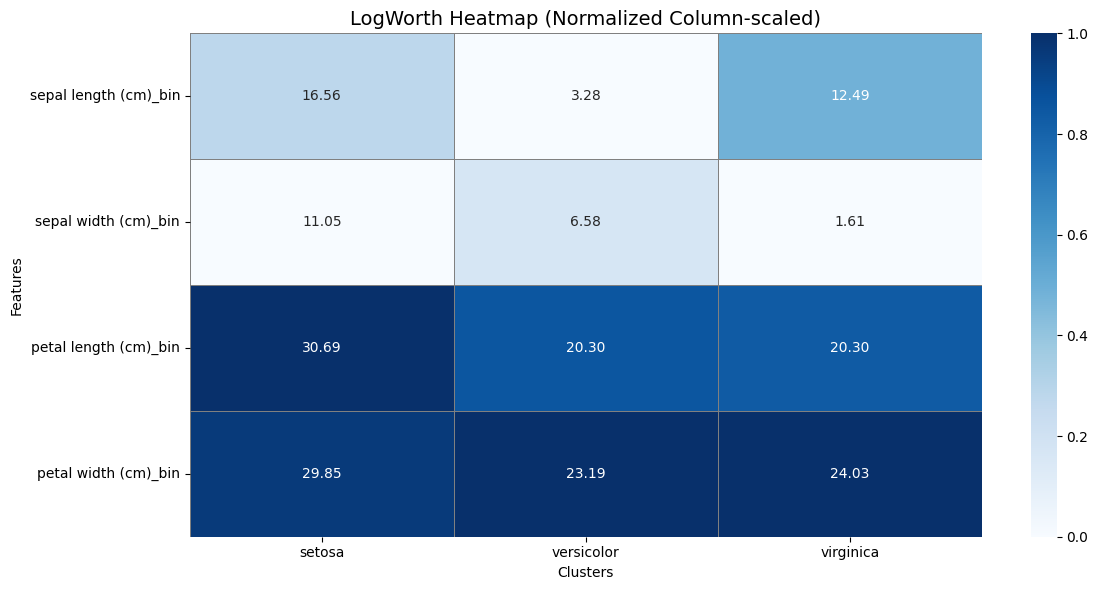

Execution time for PlotHeatmapLogworth: 0.2402 seconds


In [30]:
lean_chisq.PlotHeatmapLogworth()

# visualization

In [11]:
import post_analysis_clustering.visualize as vs

## Profile Distribution

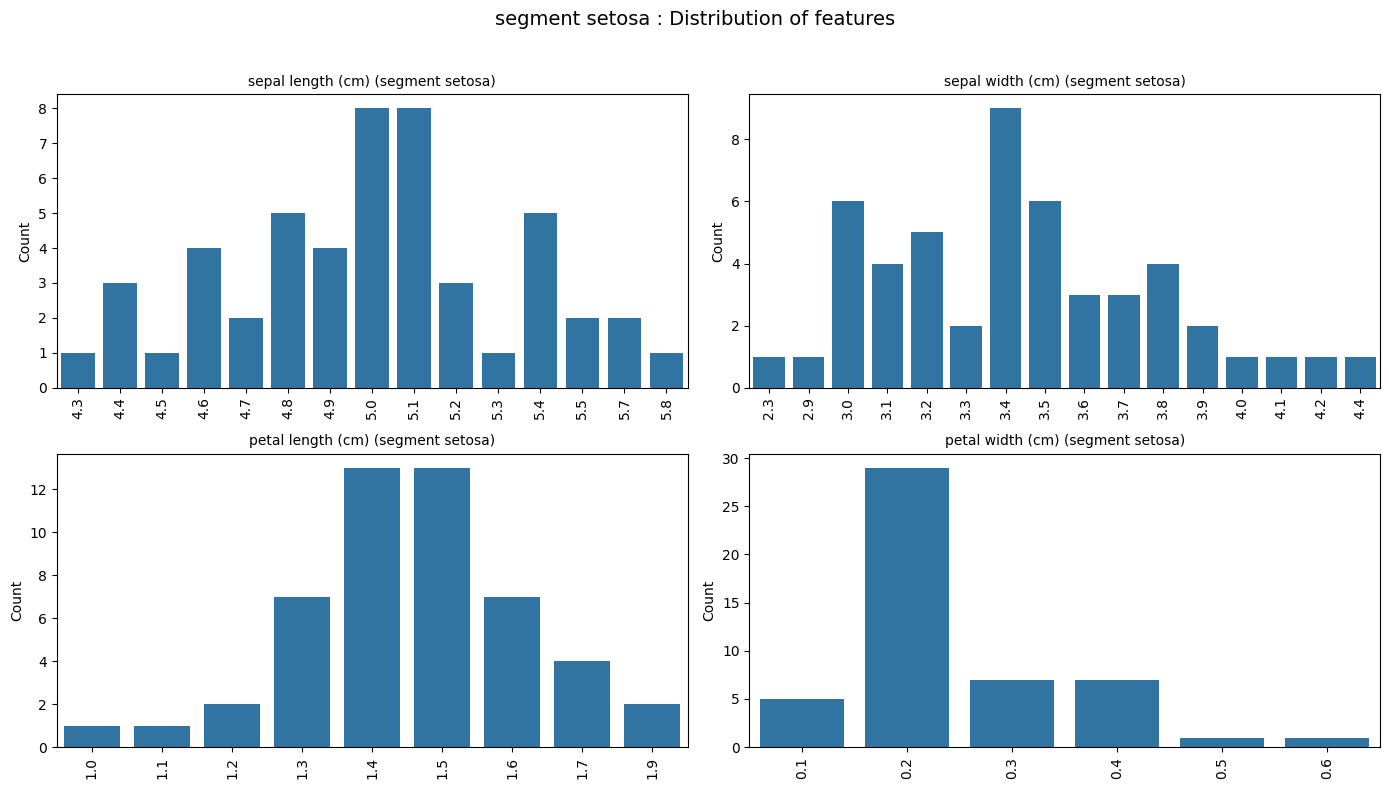

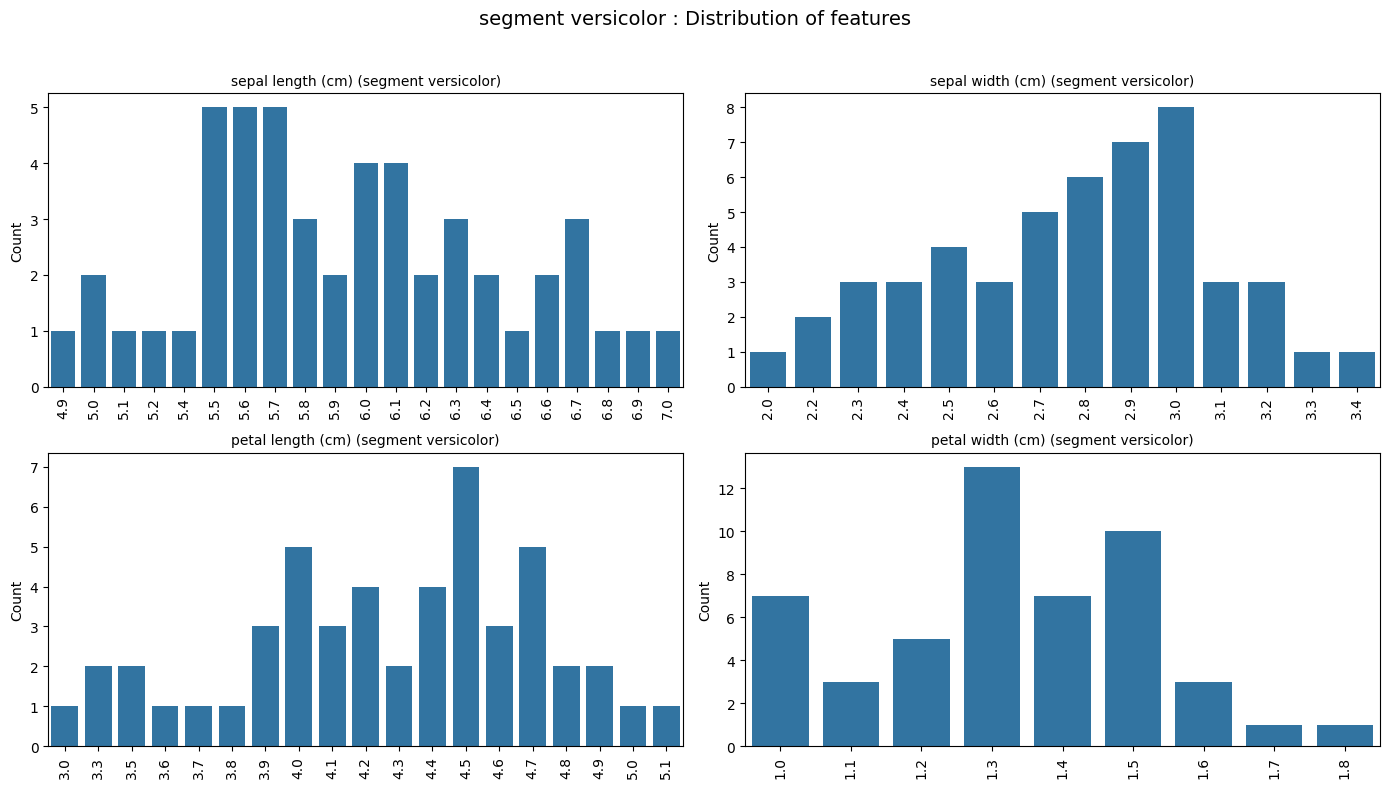

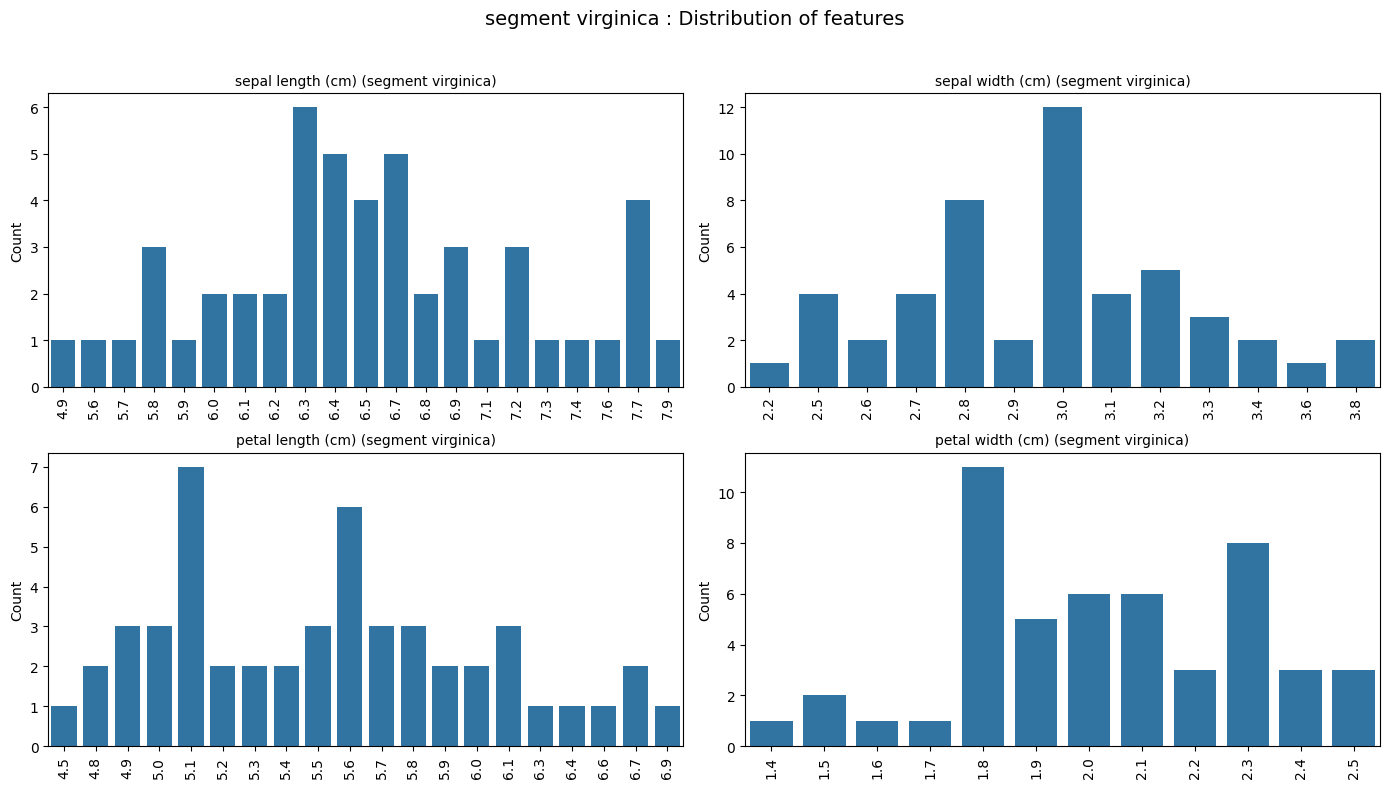

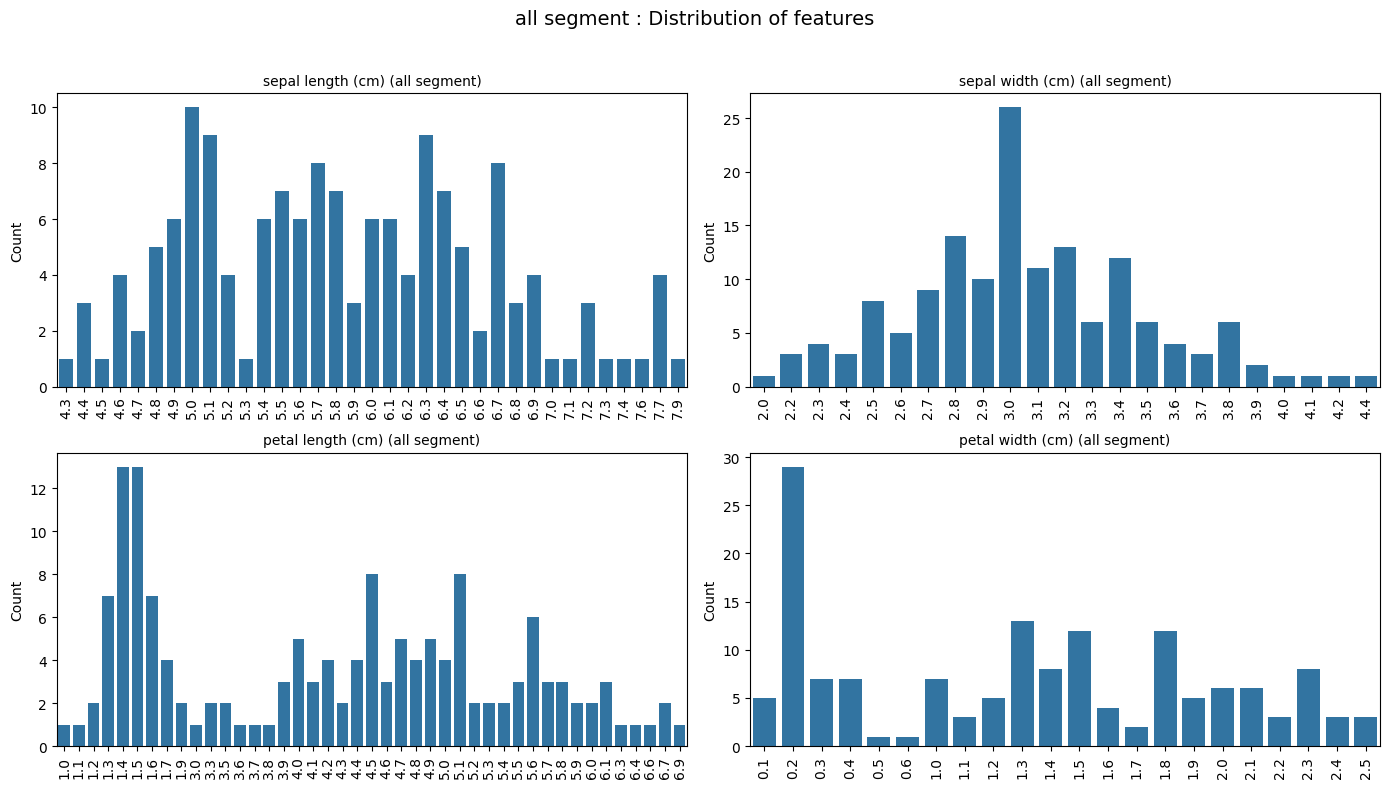

In [36]:
profile = vs.ProfileData(df=df_iris, 
                         features=iris_feature_list, 
                         target_cluster='species_name', 
                         primary_key='id')
profile.PlotAllFeatureDist(binning_keywords=['amount', 'value'], n_bins=50)

## Visualize Cluster

In [12]:
import post_analysis_clustering.visualize as vs

In [13]:
viscluster = vs.VisualizeCluster(df=df_iris, 
                         features=iris_feature_list, 
                         target_cluster='species_name', 
                         primary_key='id')

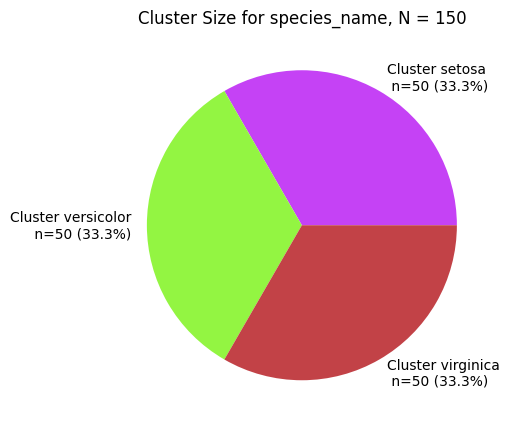

Execution time for plot_pie_cluster: 0.0893 seconds


In [14]:
viscluster.plot_pie_cluster()

#### Describe

In [18]:
viscluster.get_descriptive_stats(filter_col_keywords = None)


📊 Descriptive Statistics for sepal length (cm):
 species_name  setosa  versicolor  virginica
count          50.00       50.00      50.00
mean            5.01        5.94       6.59
std             0.35        0.52       0.64
min             4.30        4.90       4.90
25%             4.80        5.60       6.22
50%             5.00        5.90       6.50
75%             5.20        6.30       6.90
max             5.80        7.00       7.90

📊 Descriptive Statistics for sepal width (cm):
 species_name  setosa  versicolor  virginica
count          50.00       50.00      50.00
mean            3.43        2.77       2.97
std             0.38        0.31       0.32
min             2.30        2.00       2.20
25%             3.20        2.52       2.80
50%             3.40        2.80       3.00
75%             3.68        3.00       3.18
max             4.40        3.40       3.80

📊 Descriptive Statistics for petal length (cm):
 species_name  setosa  versicolor  virginica
count          

#### Violin & Box

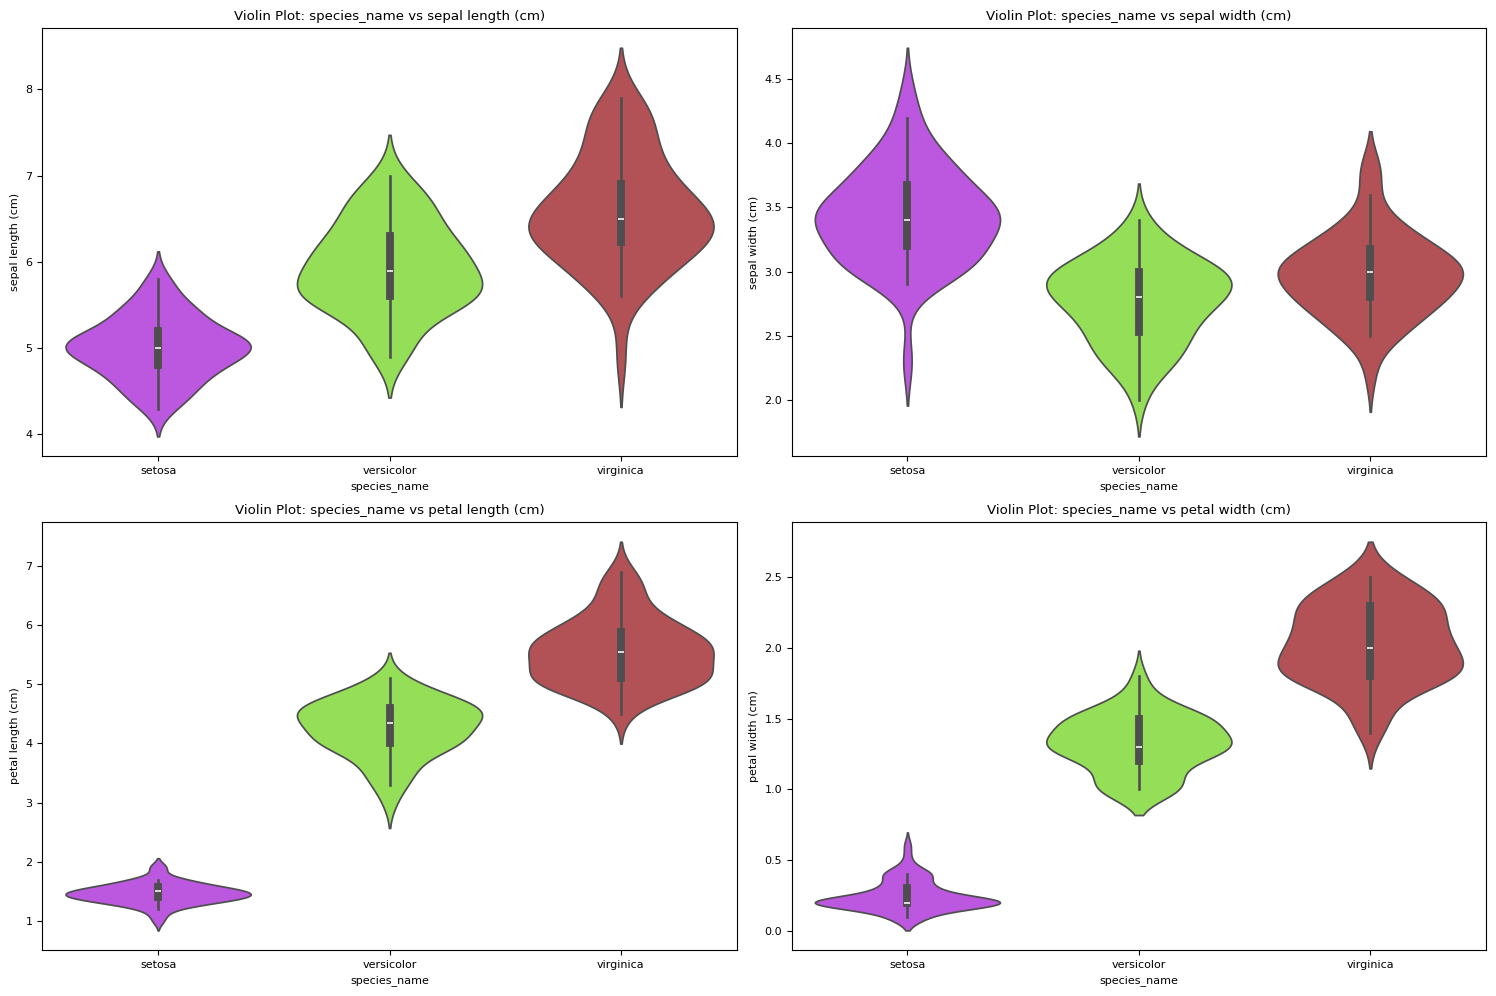

Execution time for plot_violin: 0.8358 seconds


In [20]:
viscluster.plot_violin(filter_col_keywords = None)

#### Heatmap of Freq

##### discrete

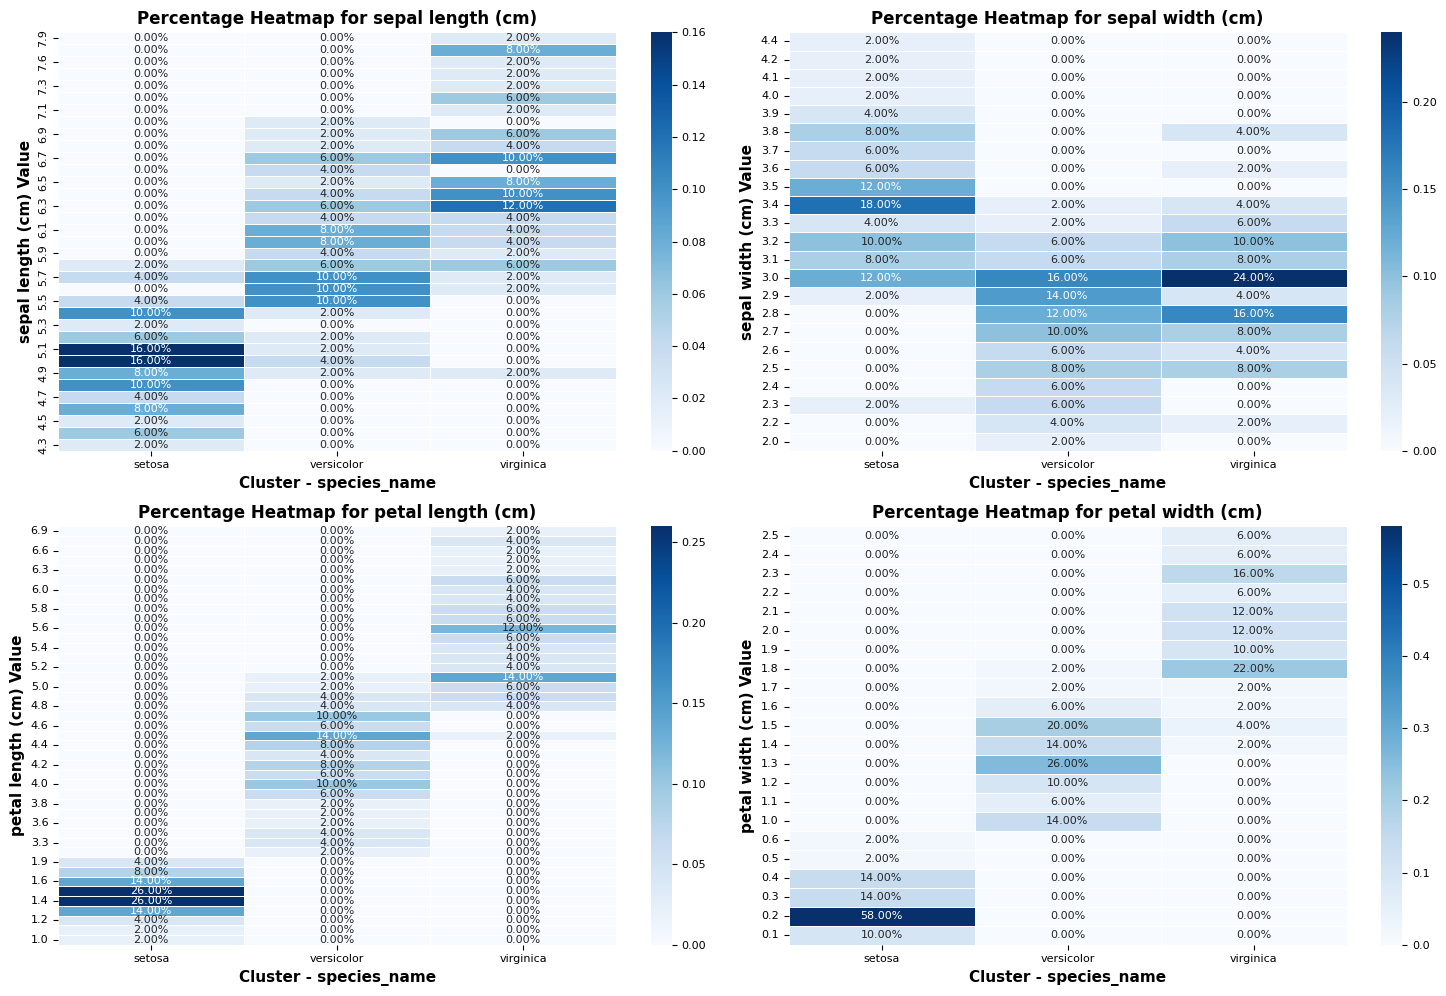

Execution time for plot_crosstab: 2.4297 seconds


In [21]:
viscluster.plot_crosstab(filter_col_keywords = None,
              compare_type='Percentage',
              annot_type='Percentage') # nunique น้อยๆ พวก count ได้

##### continuous -bin

Execution time for _prep_bin_heatmap: 0.0102 seconds
Execution time for _prep_bin_heatmap: 0.0091 seconds
Execution time for _prep_bin_heatmap: 0.0089 seconds
Execution time for _prep_bin_heatmap: 0.0097 seconds


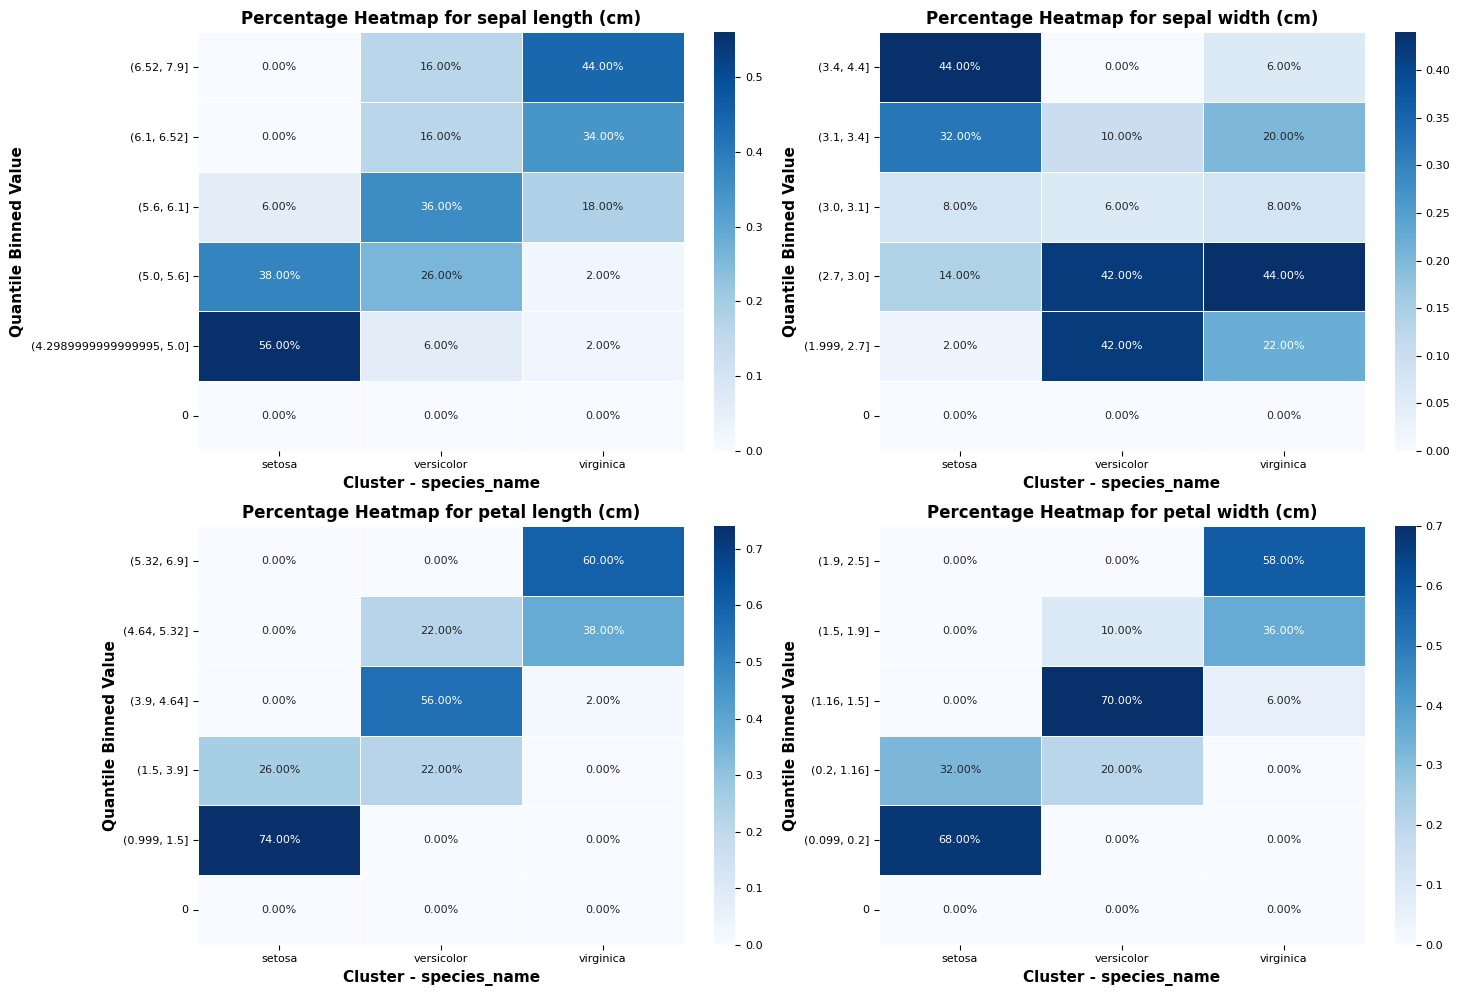

Execution time for plot_bin_heatmap: 1.3914 seconds


In [26]:
viscluster.plot_bin_heatmap(filter_col_keywords = None,
                          annot_type='Percentage'
                        )

Execution time for _prep_bin_heatmap: 0.0104 seconds
Execution time for _prep_bin_heatmap: 0.0092 seconds
Execution time for _prep_bin_heatmap: 0.0087 seconds
Execution time for _prep_bin_heatmap: 0.0093 seconds


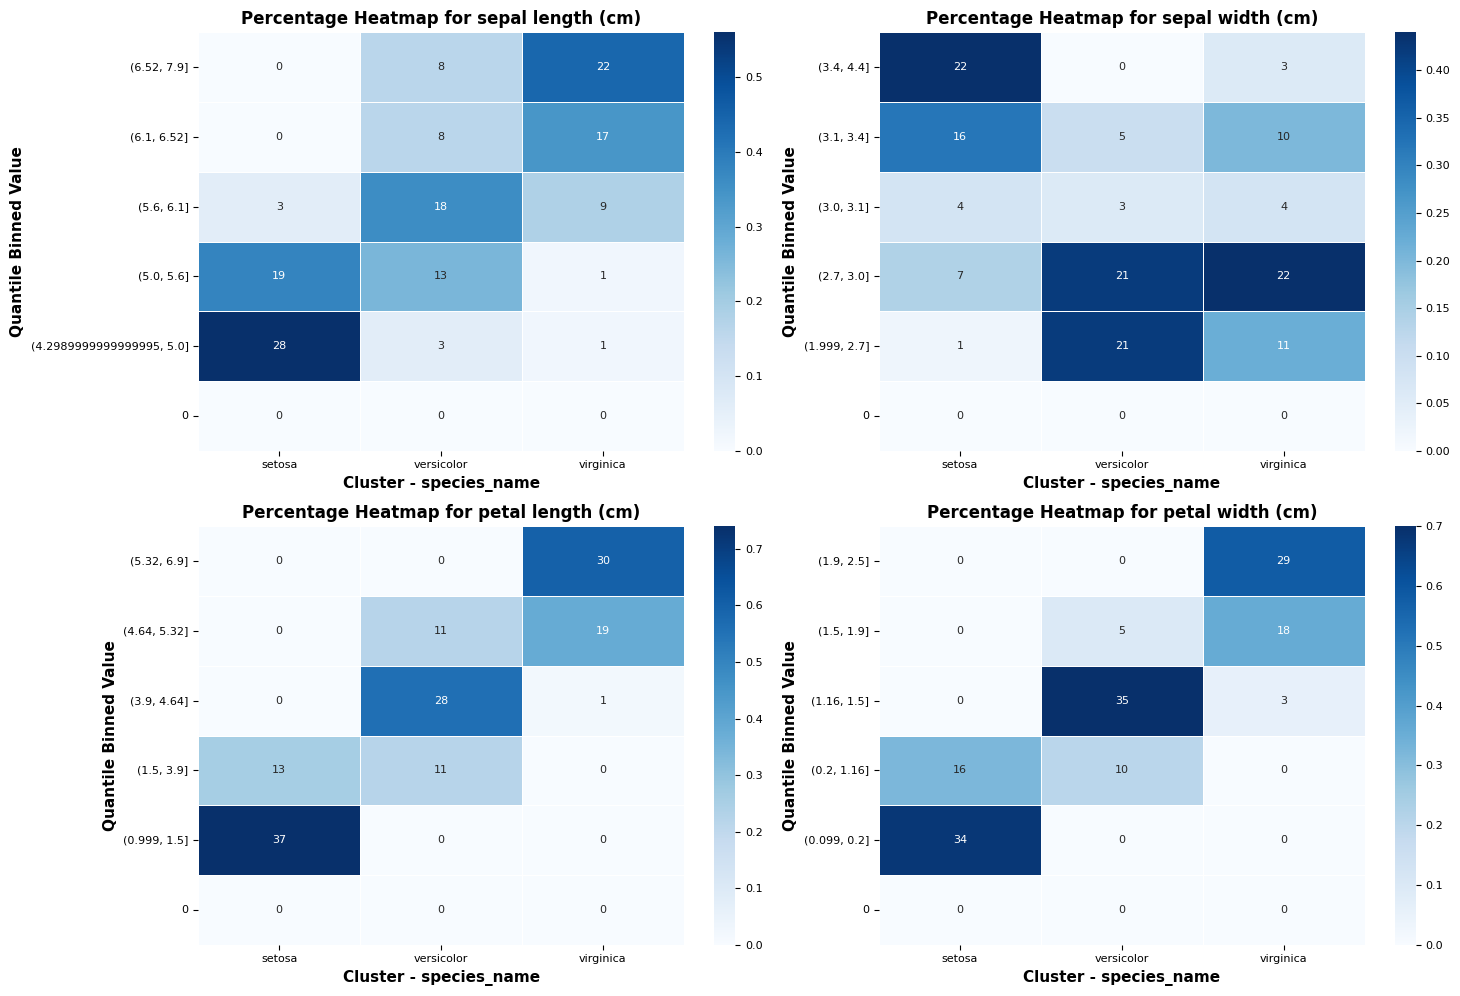

Execution time for plot_bin_heatmap: 1.3489 seconds


In [27]:
viscluster.plot_bin_heatmap(filter_col_keywords = None,
                             annot_type='Actual'
                            )

#### Snake

https://medium.com/data-science/customer-segmentation-in-online-retail-1fc707a6f9e6

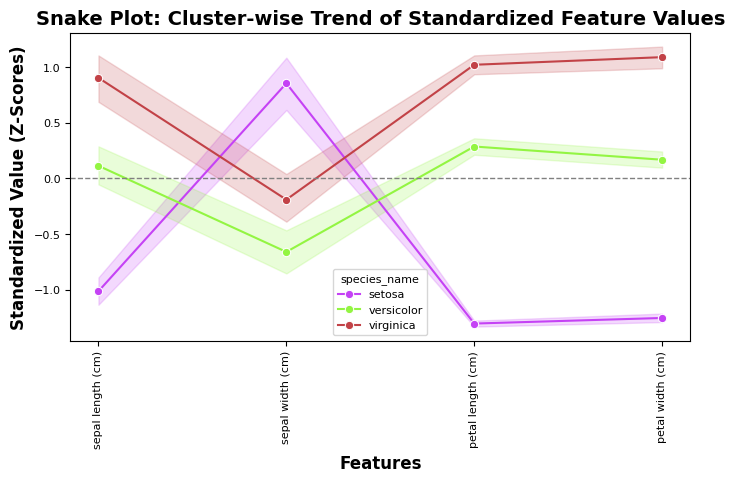

Execution time for plot_snake_scaled: 0.4114 seconds


In [28]:
viscluster.plot_snake_scaled(filter_col_keywords=None)

#### Cluster Stat

In [29]:
viscluster.cluster_feature_stats_table(
    filter_col_keywords= None, 
    stats=['count',
           'mean', 
           'mode', 
           'median', 
           'std'
          ]
    )

Execution time for cluster_feature_stats_table: 0.0230 seconds


setosa                         versicolor                   \
                    mean   std count mode median       mean   std count mode   
sepal length (cm)   5.01  0.35    50  5.0    5.0       5.94  0.52    50  5.5   
sepal width (cm)    3.43  0.38    50  3.4    3.4       2.77  0.31    50  3.0   
petal length (cm)   1.46  0.17    50  1.4    1.5       4.26  0.47    50  4.5   
petal width (cm)    0.25  0.11    50  0.2    0.2       1.33  0.20    50  1.3   

                         virginica                          
                  median      mean   std count mode median  
sepal length (cm)   5.90      6.59  0.64    50  6.3   6.50  
sepal width (cm)    2.80      2.97  0.32    50  3.0   3.00  
petal length (cm)   4.35      5.55  0.55    50  5.1   5.55  
petal width (cm)    1.30      2.03  0.27    50  1.8   2.00

#### Relative Imp

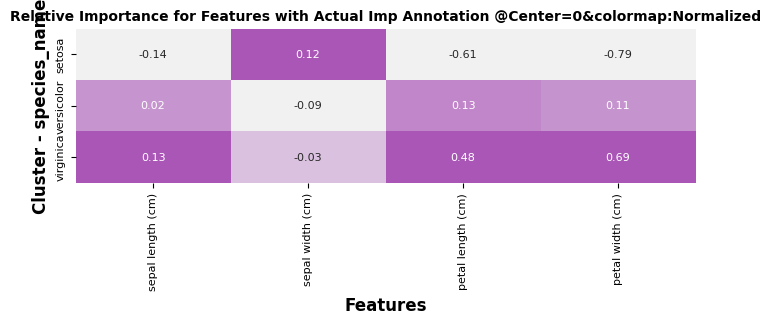

Execution time for plot_relative_imp: 0.1371 seconds


In [30]:
viscluster.plot_relative_imp(
                  filter_col_keywords=None,
                  compare_type='Normalized')

#### Group bar

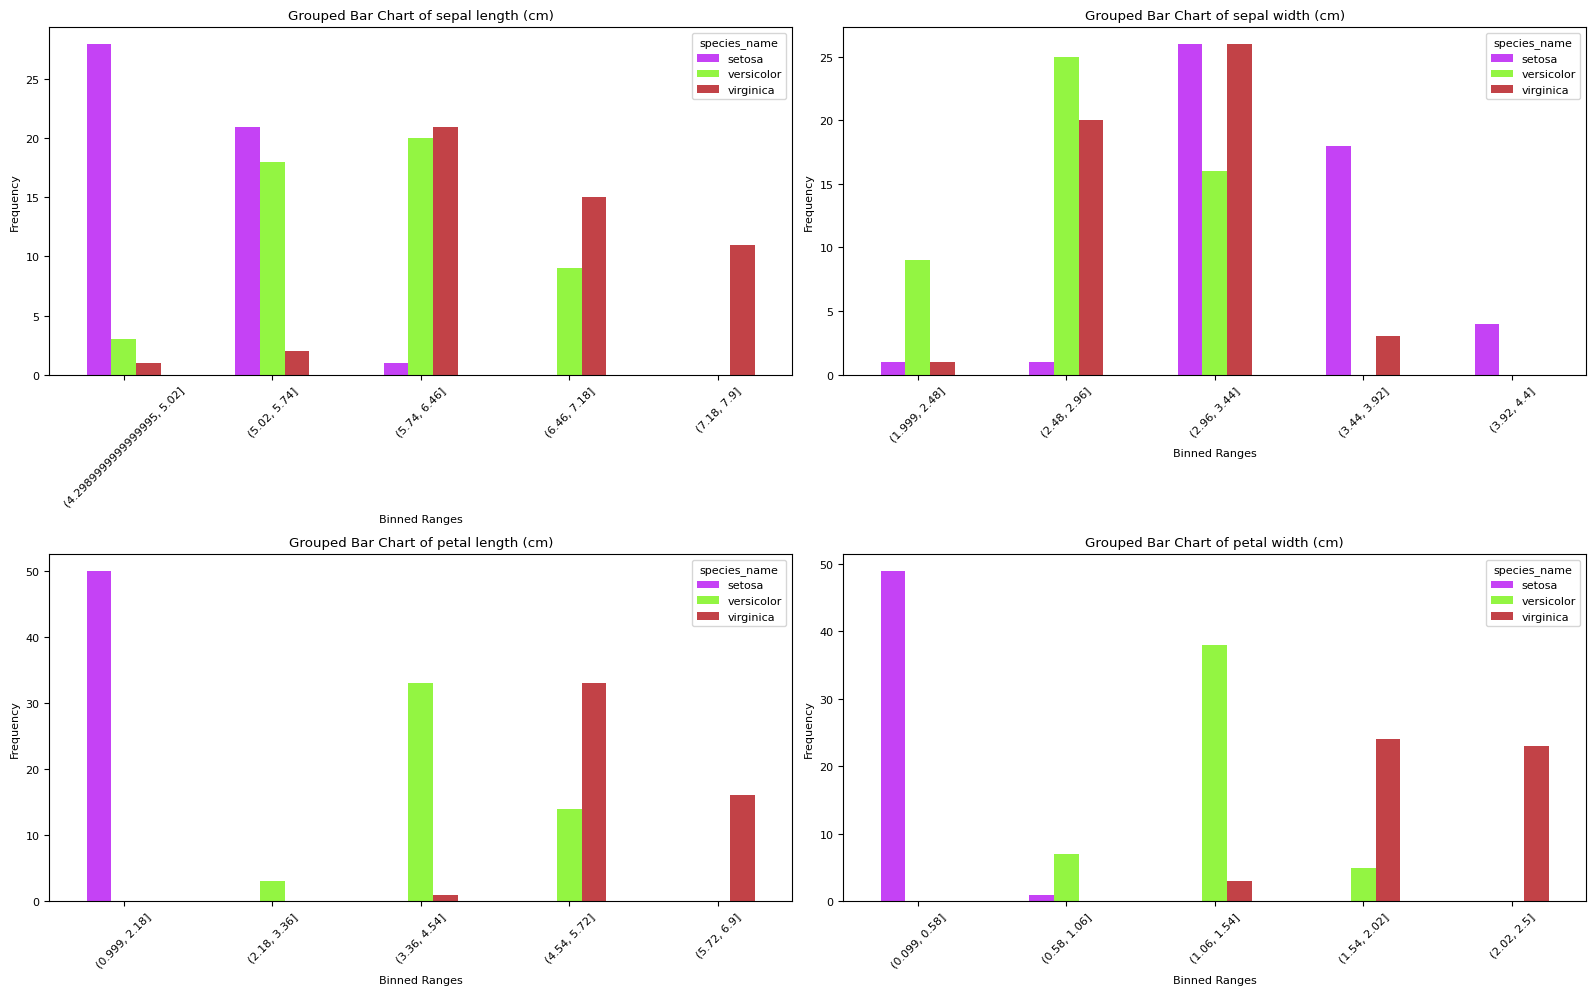

Execution time for plot_grouped_bar_by_bins: 0.7805 seconds


In [32]:
viscluster.plot_grouped_bar_by_bins(
                         filter_col_keywords=None,
                         n_bins=5
)

#### Filtered bar

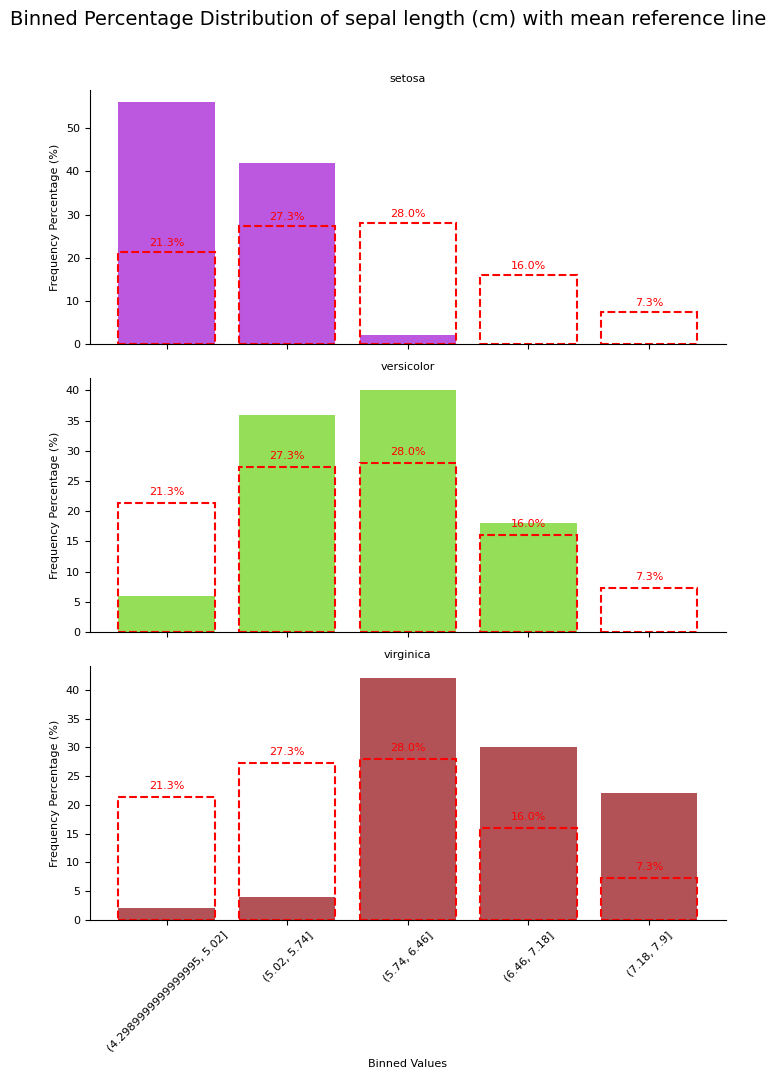

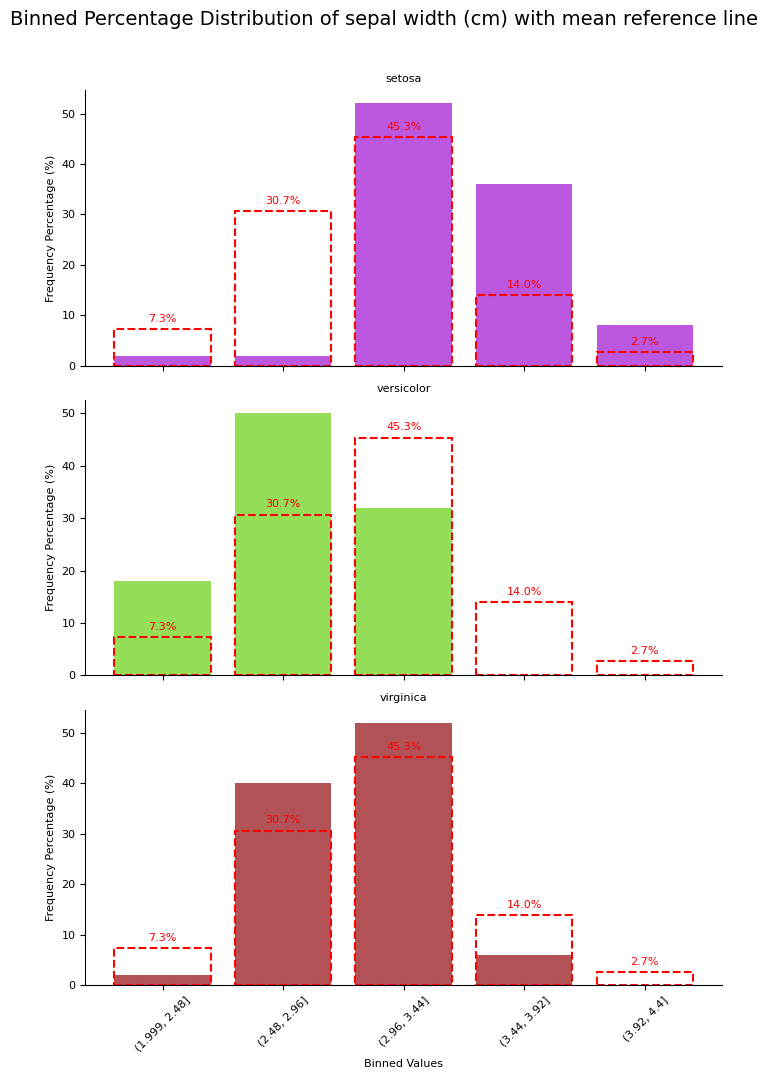

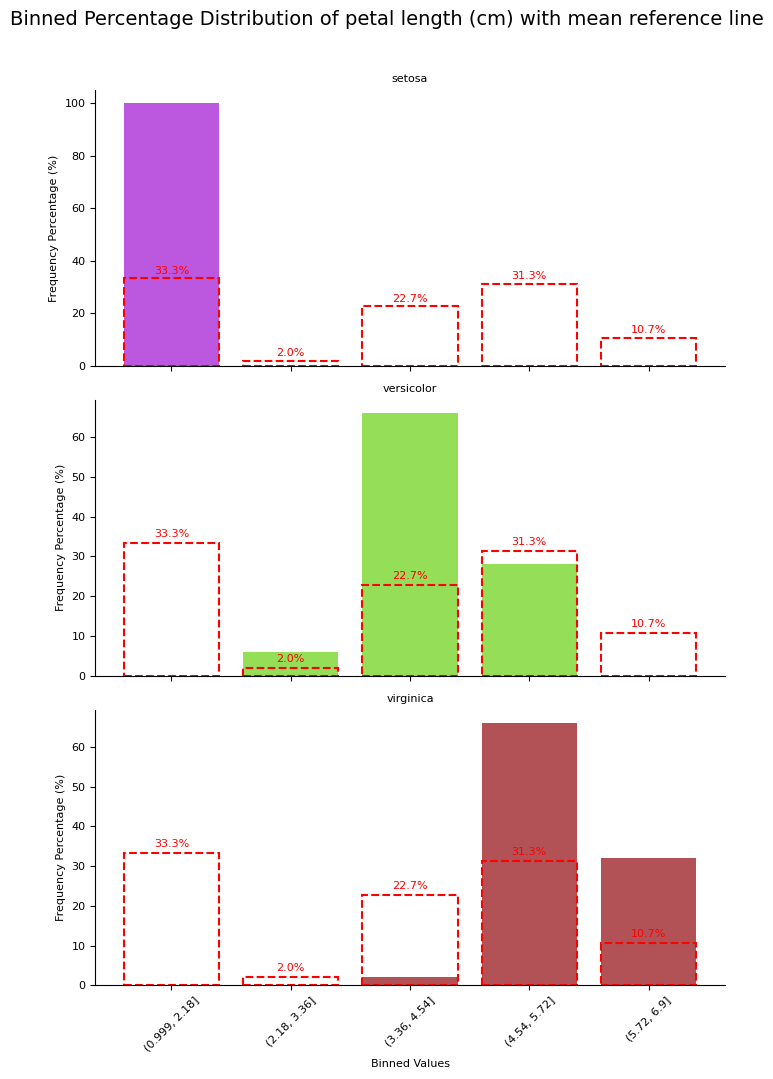

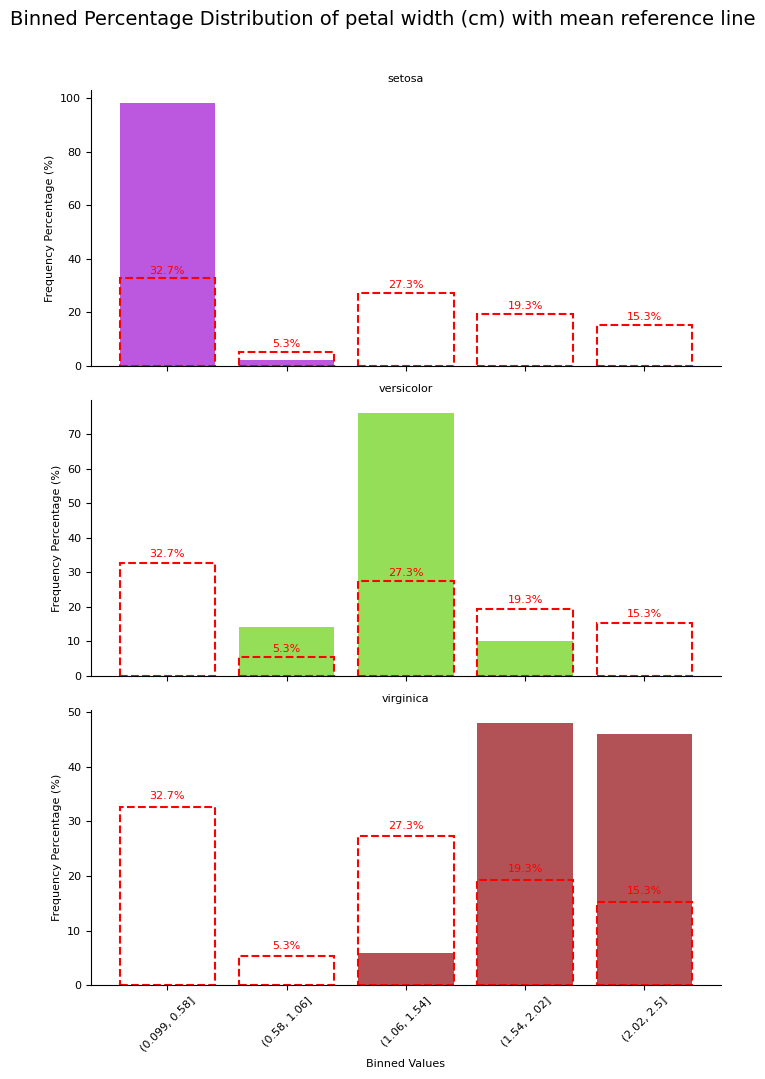

Execution time for plot_stacked_bar_by_bins: 3.3784 seconds


In [33]:
viscluster.plot_stacked_bar_by_bins( 
                         filter_col_keywords= None,
                         n_bins=5,
                         percent_by = 'segment',
                         reference_stat='mean'
)

#### Radar Chart

https://python-graph-gallery.com/392-use-faceting-for-radar-chart/

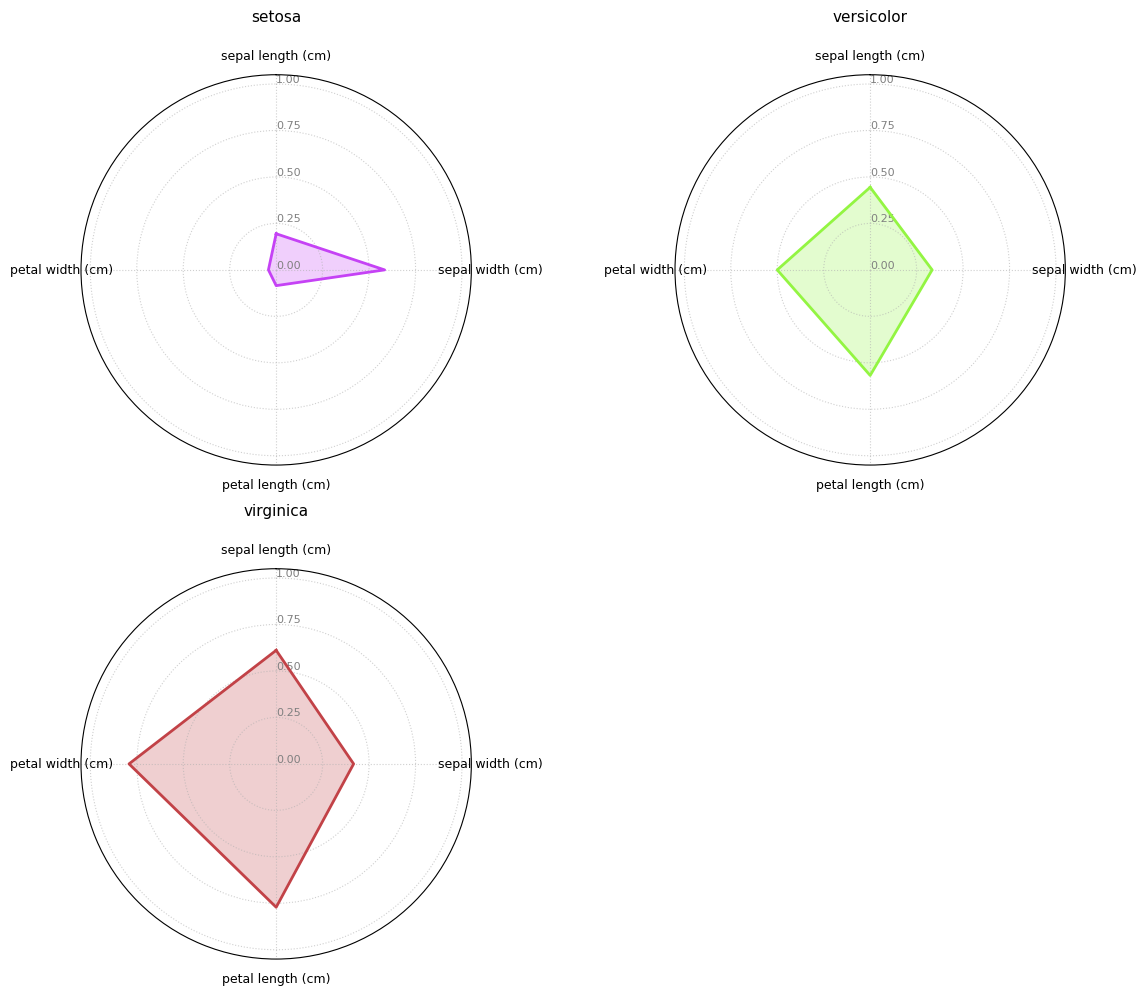

Execution time for plot_radar_chart: 0.5762 seconds


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
species_name,,,,
setosa,0.194444,0.583333,0.084746,0.041667
versicolor,0.444444,0.333333,0.567797,0.500000
virginica,0.611111,0.416667,0.771186,0.791667


In [34]:
viscluster.plot_radar_chart(
    agg_method="median",
    scaler_type = 'minmax'
)

## Overlap

In [12]:
import post_analysis_clustering.visualize as vs

In [13]:
overlap = vs.OverlapPairPlot(df=df_iris, 
                         features=iris_feature_list, 
                         target_cluster='species_name', 
                         primary_key='id')

### polygon

#### single-plot one pair

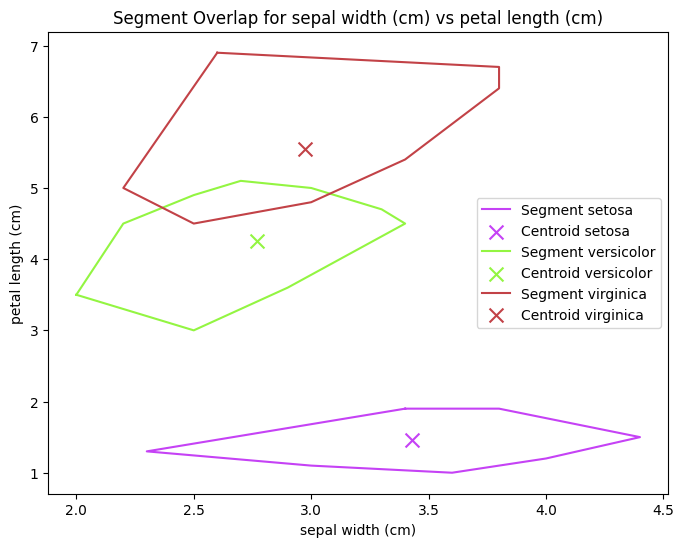

Execution time for plot_segment_overlap: 0.2185 seconds


In [14]:
overlap.plot_segment_overlap(
                     Xi = iris_feature_list[1], 
                     Xj = iris_feature_list[2], 
                        )

#### all pair

Execution time for _plot_segment_overlap_polygon_ax: 0.0144 seconds
Execution time for _plot_segment_overlap_polygon_ax: 0.0138 seconds
Execution time for _plot_segment_overlap_polygon_ax: 0.0143 seconds
Execution time for _plot_segment_overlap_polygon_ax: 0.0136 seconds
Execution time for _plot_segment_overlap_polygon_ax: 0.0140 seconds
Execution time for _plot_segment_overlap_polygon_ax: 0.0147 seconds


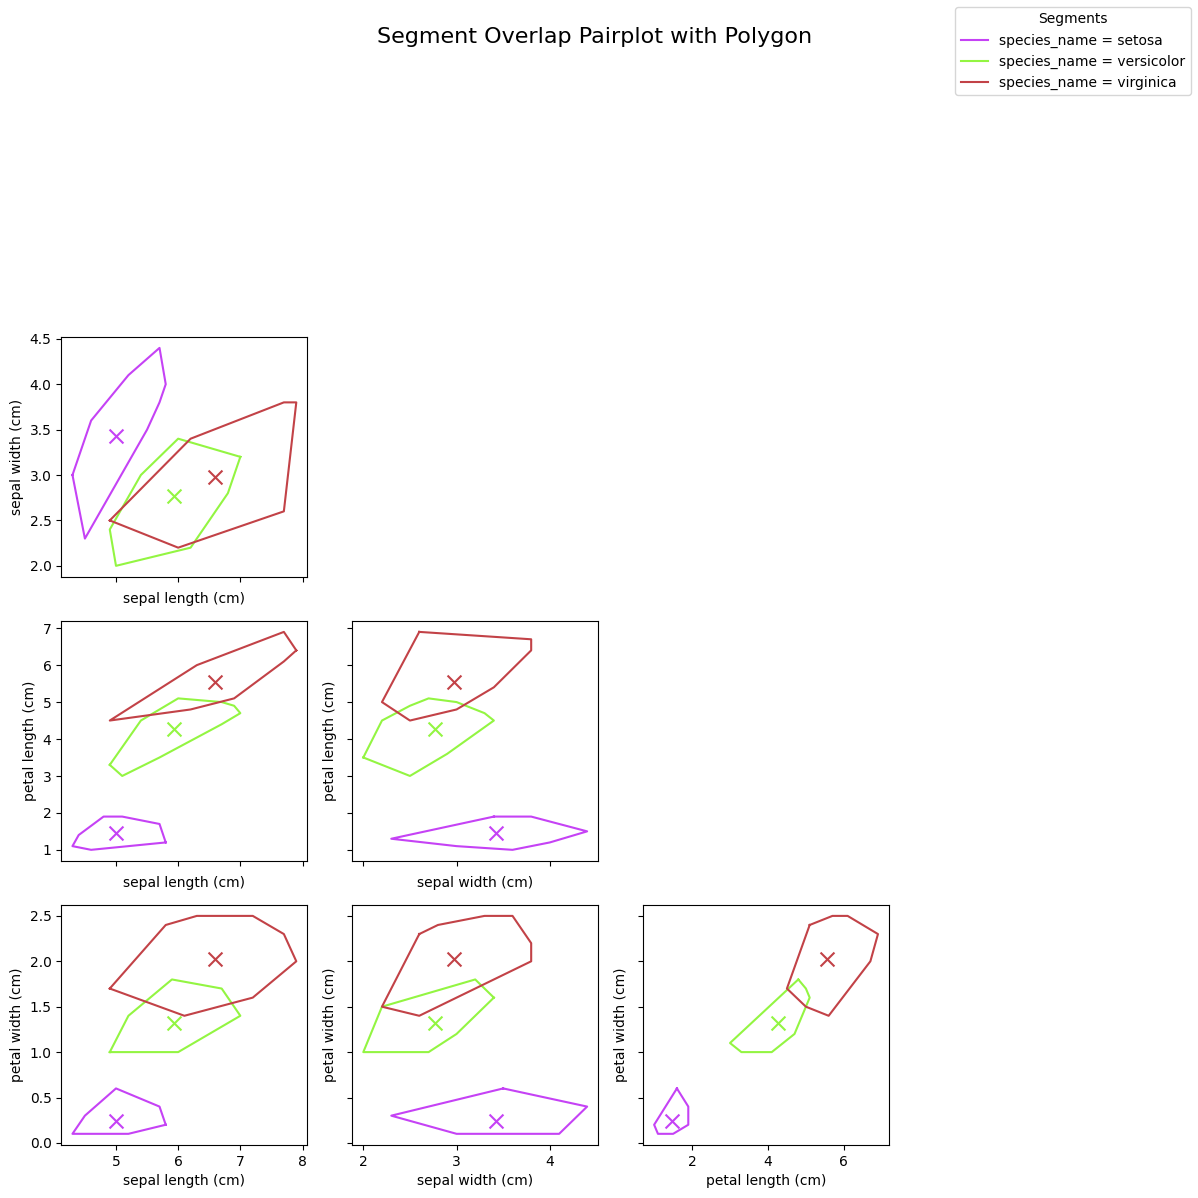

Execution time for plot_custom_polygon_pairplot: 0.8679 seconds


In [15]:
overlap.plot_custom_polygon_pairplot()

### ellipse

#### single-plot one pair

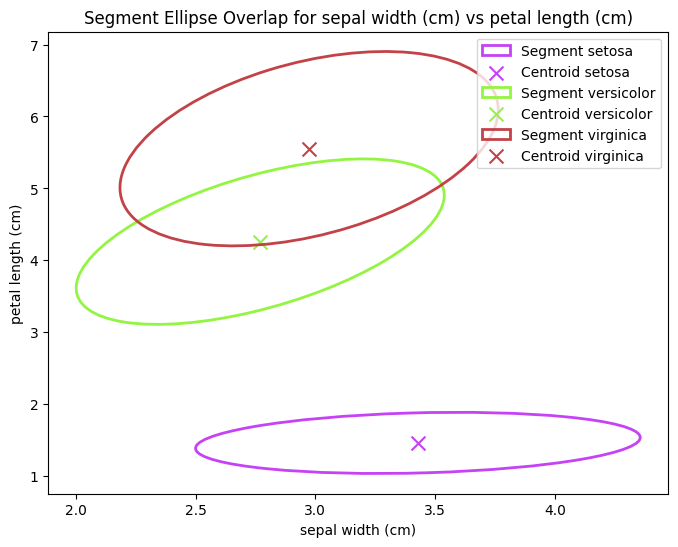

Execution time for plot_segment_ellipse: 0.2056 seconds


In [22]:
overlap.plot_segment_ellipse(
                     Xi = iris_feature_list[1], 
                     Xj = iris_feature_list[2], 
                     confidence_level=  0.95,
                        )

#### all pair

Execution time for _plot_segment_ellipse_ax: 0.0208 seconds
Execution time for _plot_segment_ellipse_ax: 0.0240 seconds
Execution time for _plot_segment_ellipse_ax: 0.0208 seconds
Execution time for _plot_segment_ellipse_ax: 0.0241 seconds
Execution time for _plot_segment_ellipse_ax: 0.0213 seconds
Execution time for _plot_segment_ellipse_ax: 0.0206 seconds


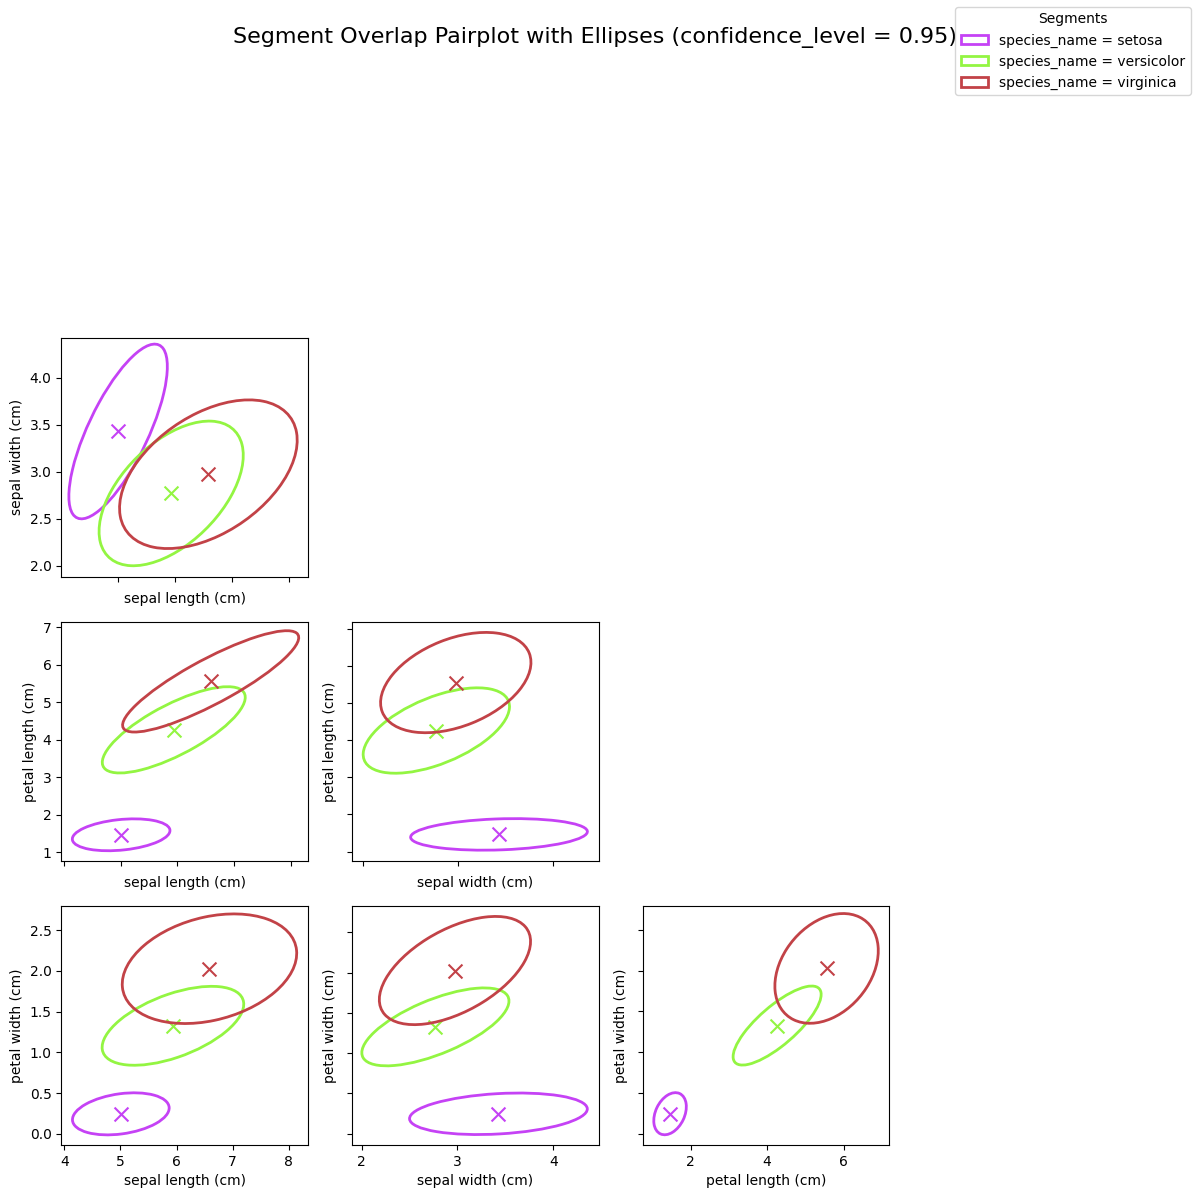

Execution time for plot_custom_ellipse_pairplot: 0.9404 seconds


In [21]:
overlap.plot_custom_ellipse_pairplot(
              confidence_level=0.95
              )

## Dimensionality Reduction

In [11]:
import post_analysis_clustering.visualize as vs

In [14]:
dimred = vs.DimensionalityReduction(df=df_iris, 
                         features=iris_feature_list, 
                         target_cluster='species_name', 
                         primary_key='id',
                         scale = True,
                         sample_size= None,
                         stratify = True)

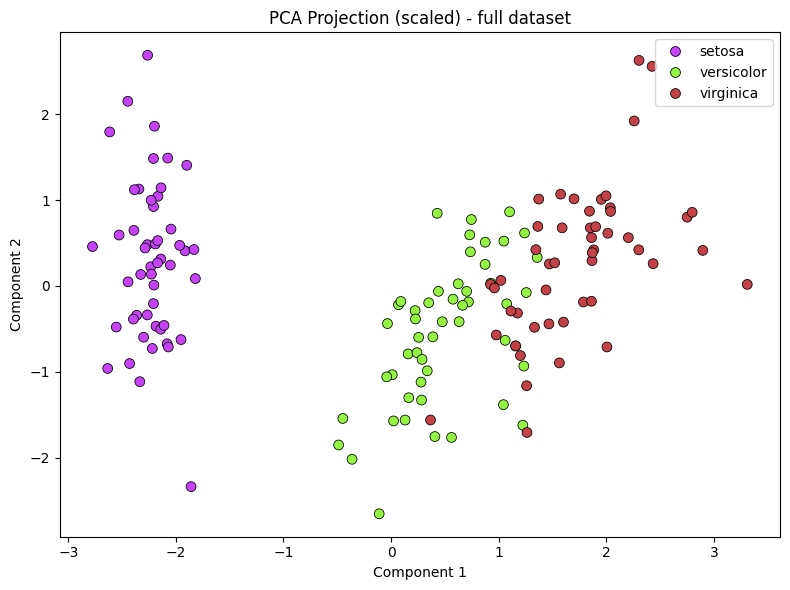

Execution time for plot_dim_reduction: 0.2284 seconds


In [15]:
dimred.plot_dim_reduction(
    method='pca',
    n_components=2,
    title=None,
)

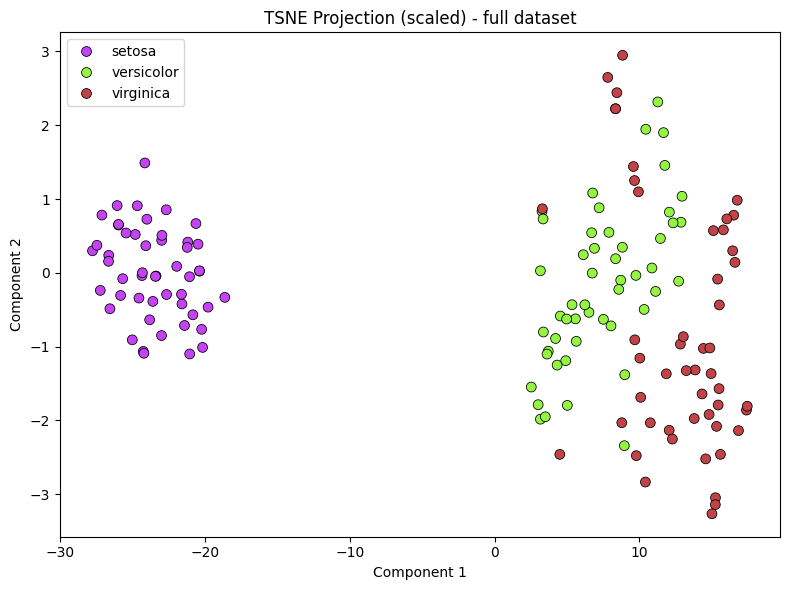

Execution time for plot_dim_reduction: 0.7370 seconds


In [16]:
dimred.plot_dim_reduction(
    method='tsne',
    n_components=2,
    title=None,
)

## Performance Metrics

#####  Silhouette Score
Measures how similar a point is to its own cluster compared to others.  
**Range:** -1 to 1 | **Higher is better**

---

##### Davies-Bouldin Index
Evaluates average similarity between clusters based on distance and spread.  
**Range:** 0 to ∞ | **Lower is better**

---

##### Calinski-Harabasz Index
Assesses cluster separation and compactness using dispersion ratios.  
**Range:** 0 to ∞ | **Higher is better**

---


In [12]:
import post_analysis_clustering.visualize as vs

In [13]:
perf = vs.PerformanceMetrics(df=df_iris, 
                         features=iris_feature_list, 
                         target_cluster='species_name', 
                         primary_key='id',
                         scale=True,
                         sample_size=None,
                         stratify=True
                            )

Execution time for _compute_cluster_metrics: 0.0091 seconds


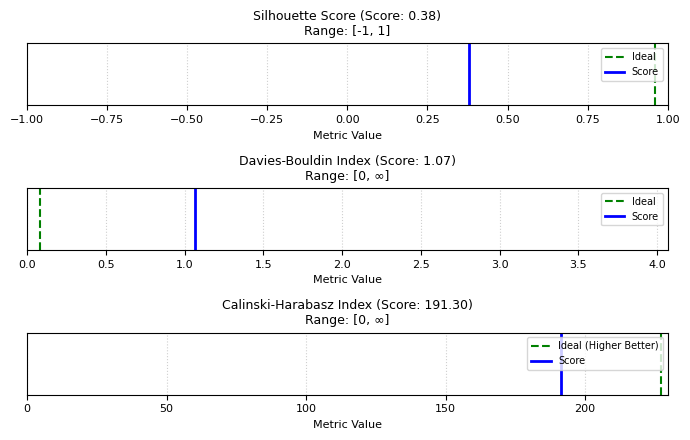

Execution time for plot_cluster_metric_ranges: 0.3366 seconds


In [14]:
perf.plot_cluster_metric_ranges()

In [16]:
# pending : [method] run (?) pull ทั้ง 3 method ให้รันออกมาพร้อมกัน -> get final result & union
# pending : add docstring